# Distribution of Accuracy

Let's define $a_i(x)$ to be 1 if the i-th classifier's output on $x$ is correct, and 0 otherwise. Then $\mathop{\mathbb{E}} [a_i(x)]$ is the i-th classifier's accuracy on all possible datasets. In this analysis, the accuracy of every classifier is the same.

$$
x \sim p_{data}
\\
a_i(x) \in \mathbb{R}^n \rightarrow \{0, 1\}
$$

$$
a_i(x) \sim \text{Bernoulli}(p)
\\
\mathbb{E}[\ a_i(x)\ ] = p
$$

An ensemble of $s$ classifiers with majority vote rule can be defined as:

$$
e(x) = {\lceil} \sum_i^s \frac{a_i(x)}{s} {\rceil}
\\
e(x) \sim \text{Binomial}(p, s) > \frac{s}{2}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')

In [315]:
prob_curve = pd.DataFrame()
prob_curve['Member'] = np.linspace(0, 1, 100)
prob_curve['Ensemble'] = [
    ensemble_independent_bernoulli(
            prob=prob,
            n_members=20, 
            n_samples=int(1e4), 
            seed=42
        ).mean()
    for prob in prob_curve['Member']
]
prob_curve.round(2)[::20]

,Member,Ensemble
0,0.00,0.00
20,0.20,0.00
40,0.40,0.13
60,0.61,0.77
80,0.81,1.00


In [236]:
def bernoulli(prob, n_samples=1, seed=None):
    np.random.seed(seed)
    return np.random.rand(n_samples) < prob

def ensemble_independent_bernoulli(prob, n_members, n_samples, seed=None):
    
    # Each member needs a different seed to be independent.
    np.random.seed(seed)
    seeds = [
        np.random.randint(1e6)
        for _ in range(n_members)
    ]
    
    member_samples = np.array([
        bernoulli(prob, n_samples, seed)
        for seed in seeds
    ])
    
    # Ensemble is accurate iff
    # the majority is accurate.
    ensemble_samples = member_samples.mean(axis=0) > 0.5
    
    return ensemble_samples

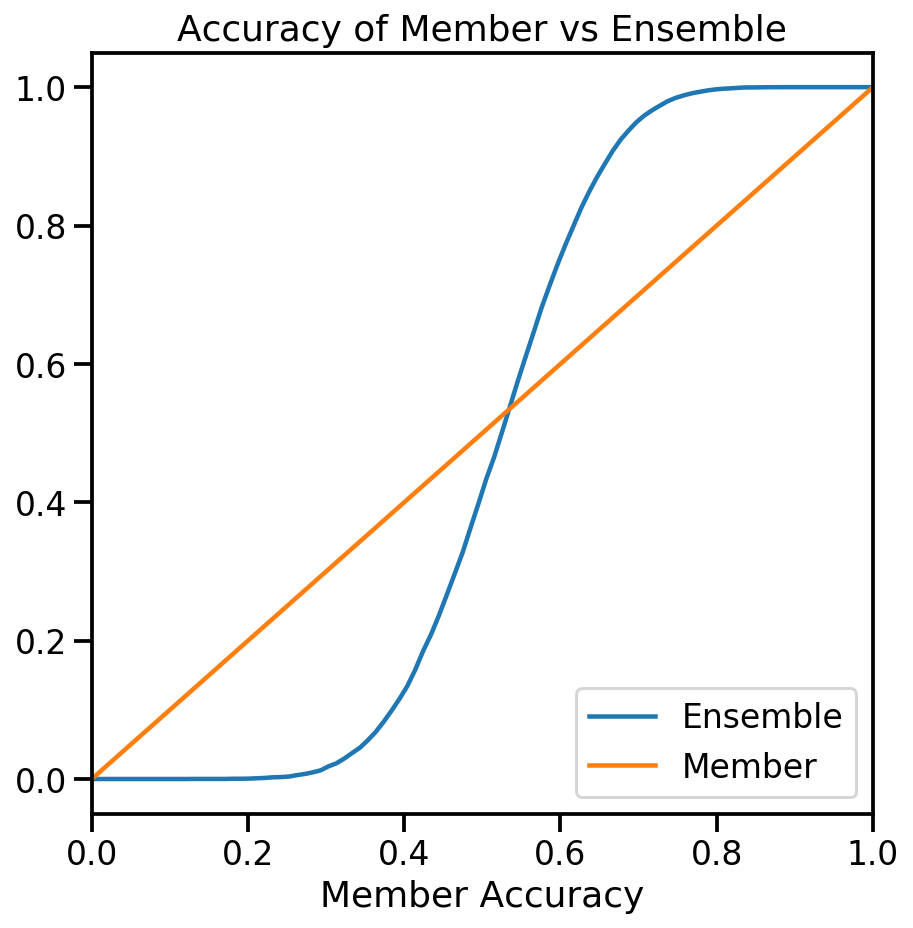

In [316]:
prob_curve.plot(
    'Member', 
    'Ensemble', 
    figsize=[7, 7]
)
plt.plot([0, 1], [0, 1], label='Member')
plt.title('Accuracy of Member vs Ensemble')
plt.xlabel('Member Accuracy')
plt.legend(loc='lower right')
plt.show()

In [290]:
def size_curve(prob, n_samples):
    curve = pd.DataFrame()
    sizes = np.arange(2, 40, 2)

    curve['ensemble accuracy'] = [
        ensemble_independent_bernoulli(
            prob=prob,
            n_members=size, 
            n_samples=n_samples, 
            seed=42
        ).mean()
        for size in sizes
    ]
    
    curve.index = sizes
    curve.index.name = 'ensemble size'
    
    return curve

size_curve(prob=0.7, n_samples=10)[::5]

,ensemble accuracy
ensemble size,
2,0.3
12,0.9
22,0.9
32,1.0


In [333]:
probs = np.linspace(0.6, 0.9, 10)

size_curves = [
    size_curve(
        prob=prob,
        n_samples=int(1e5)
    )
    for prob in probs
]

size_curves = pd.concat(size_curves, keys=probs, names=['prob'])

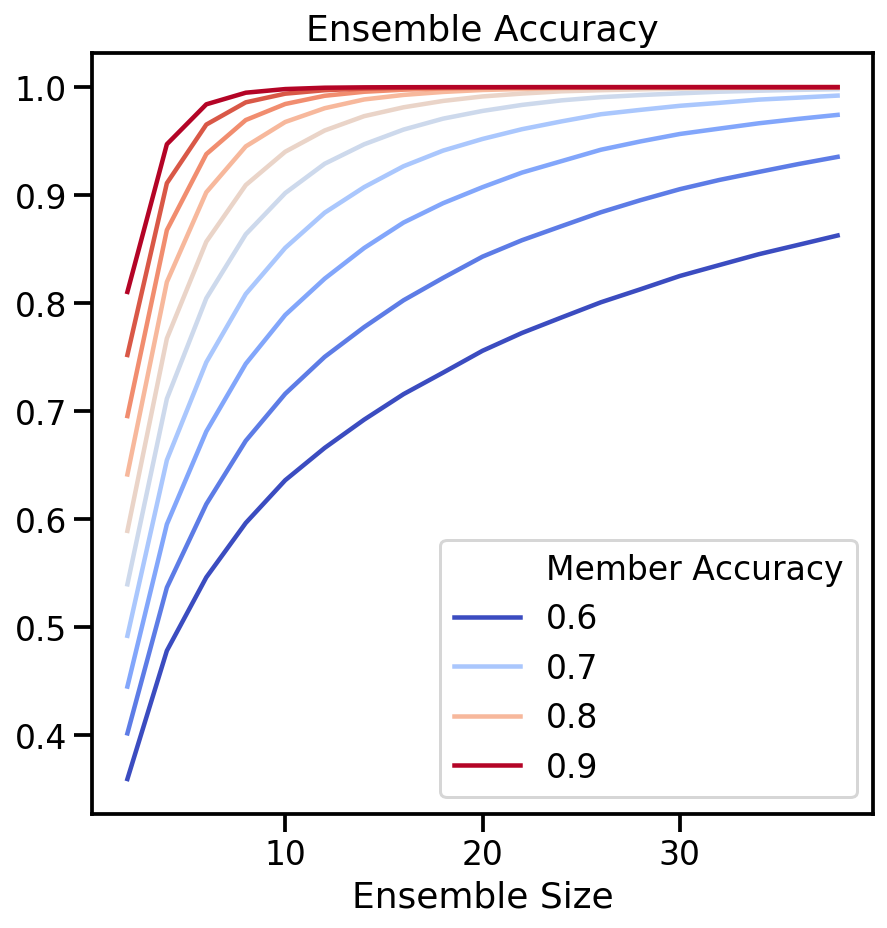

In [300]:
pretty_size_curves = size_curves\
    .reset_index()\
    .rename(columns={
        'prob': 'Member Accuracy',
        'ensemble size': 'Ensemble Size',
    })\
    .astype('float32')

plt.figure(figsize=[7, 7])
sns.lineplot(
    x='Ensemble Size', 
    y='ensemble accuracy', 
    hue='Member Accuracy',
    data=pretty_size_curves,
    palette='coolwarm'
)
plt.ylabel('')
plt.title('Ensemble Accuracy')
plt.show()

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cross(cross):
    mask = np.zeros_like(cross, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))

    sns.heatmap(
        cross, 
        cmap='coolwarm', 
        center=0,
        square=True, 
        linewidths=.5, 
        cbar_kws={"shrink": .5}
    )

In [319]:
def ensemble_correlated_bernoulli(
    marginal_prob, 
    copy_prob, 
    n_vars, 
    n_samples, 
    seed=None
):
    """
    Samples from a multivariate Bernoulli distribution,
    where individual variables are correlated.
    
    Interdependence introduced by syncing variables with 
    probability copy_prob for each sample.
    """
  
    # Each variable needs a different seed to be independent.
    np.random.seed(seed)
    seeds = [
        np.random.randint(1e6)
        for _ in range(n_vars)
    ]
    
    # Independent variable samples
    samples = np.array([
        bernoulli(
            marginal_prob, 
            n_samples, 
            seed
        )
        for seed in seeds
    ])
    
    # Creates a matrix where every variable has the same random response.
    np.random.seed(seed)
    copy_vals = np.random.rand(n_samples) < marginal_prob
    copy_vals = np.repeat(copy_vals, n_vars).reshape(n_samples, n_vars).T
    
    # Determines variable/sample pairs that will be synced
    copy_mask = np.random.rand(n_vars, n_samples) < copy_prob
    samples[copy_mask] = copy_vals[copy_mask]
    
    return samples

In [320]:
mvb = ensemble_correlated_bernoulli(
    marginal_prob=0.7, 
    copy_prob=0.8, 
    n_vars=10, 
    n_samples=int(1e4),
    seed=42
)

,0,1,2,3,4,5,6,7,8,9
0,1.00,0.64,0.64,0.64,0.64,0.63,0.63,0.64,0.64,0.63
1,0.64,1.00,0.65,0.65,0.65,0.65,0.66,0.65,0.66,0.66
2,0.64,0.65,1.00,0.65,0.65,0.64,0.66,0.64,0.65,0.64
3,0.64,0.65,0.65,1.00,0.64,0.65,0.65,0.65,0.65,0.63
4,0.64,0.65,0.65,0.64,1.00,0.65,0.65,0.63,0.64,0.64
5,0.63,0.65,0.64,0.65,0.65,1.00,0.65,0.64,0.64,0.64
6,0.63,0.66,0.66,0.65,0.65,0.65,1.00,0.65,0.65,0.64
7,0.64,0.65,0.64,0.65,0.63,0.64,0.65,1.00,0.64,0.63
8,0.64,0.66,0.65,0.65,0.64,0.64,0.65,0.64,1.00,0.64
9,0.63,0.66,0.64,0.63,0.64,0.64,0.64,0.63,0.64,1.00


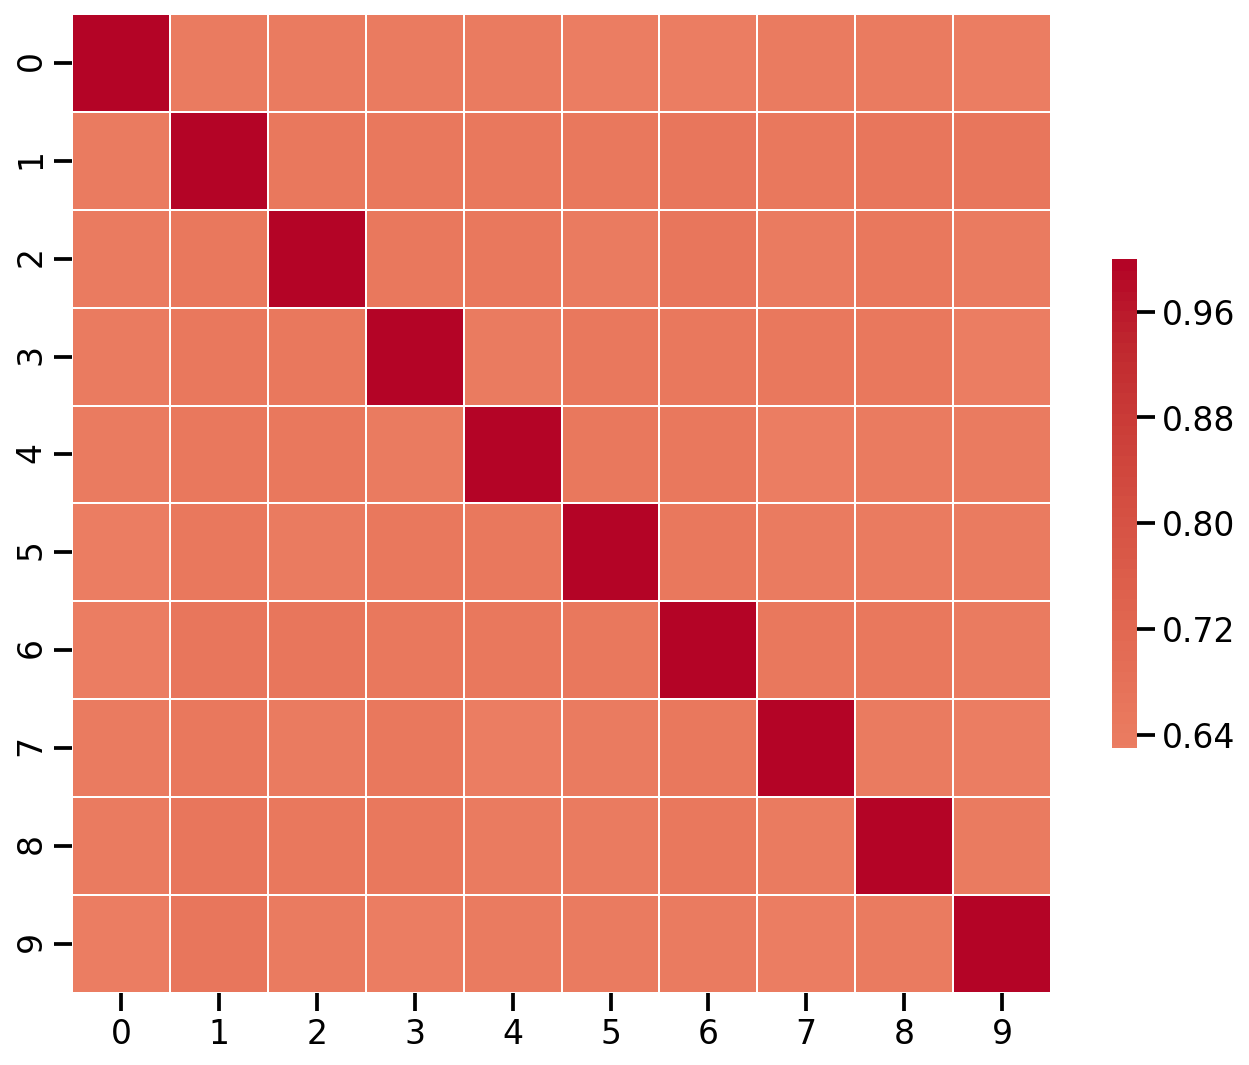

In [321]:
corrs = pd.DataFrame(np.corrcoef(mvb)).round(2)
plot_cross(corrs)
corrs

In [323]:
def mean_corr(corr_mat):
    
    # Puts zeros into main diagonal and everything above it 
    corr_mat = np.tril(corr_mat, k=-1)

    # Flattens the matrix into a vector
    corr_mat = corr_mat.ravel() 

    # Removes zeros from the vector
    corr_mat = corr_mat[corr_mat.nonzero()]

    return corr_mat.mean()


def corr_curve(n_points, n_members, n_samples, marginal_prob):
    
    corr_curve = pd.DataFrame(columns=[
        'member_accuracy',
        'ensemble_accuracy', 
        'member_mean_corr'
    ])
    
    copy_probs = np.linspace(0, 1, n_points)
    
    mvb_by_cp = [
        ensemble_correlated_bernoulli(
            marginal_prob=marginal_prob, 
            copy_prob=copy_prob, 
            n_vars=n_members, 
            n_samples=n_samples,
            seed=None
        )
        for copy_prob in copy_probs
    ]
    
    corr_curve['ensemble_accuracy'] = [
        (mvb.mean(axis=0) > 0.5).mean()
        for mvb in mvb_by_cp
    ]
    
    corr_curve['member_accuracy'] = [
        mvb.mean()
        for mvb in mvb_by_cp
    ]
    
    corr_curve['member_mean_corr'] = [
        mean_corr(np.corrcoef(mvb)) 
        for mvb in mvb_by_cp
    ]
    
    corr_curve.index = copy_probs
    corr_curve.index.name = 'copy_prob'   
    
    return corr_curve

In [334]:
corr_curves = [
    corr_curve(
        n_points = 50,
        n_members = 100,
        n_samples = int(1e5),
        marginal_prob=prob
    )
    for prob in probs
]

corr_curves = pd.concat(
    corr_curves, 
    keys=probs, 
    names=['marginal_prob'], 
    axis=0
)

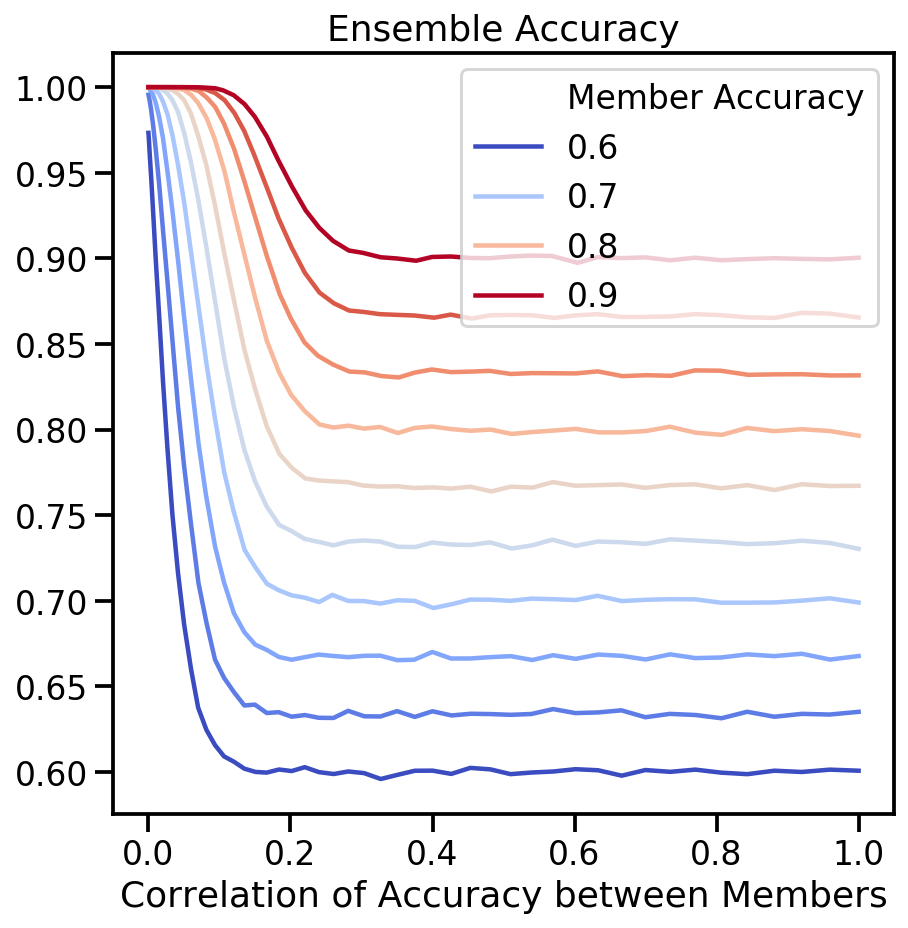

In [335]:
pretty_corr_curves = corr_curves\
    .reset_index()\
    .astype('float32')\
    .rename(columns={
        'member_mean_corr': 'Correlation of Accuracy between Members',
        'marginal_prob': 'Member Accuracy'
    })

plt.figure(figsize=[7, 7])
sns.lineplot(
    x='Correlation of Accuracy between Members', 
    y='ensemble_accuracy', 
    hue='Member Accuracy', 
    palette='coolwarm',
    data=pretty_corr_curves
)

plt.title('Ensemble Accuracy')
plt.ylabel('')
plt.legend(loc='upper right')
plt.show()

In [343]:
n_member_levels = np.arange(10, 100, 5)

corr_size_curves = [
    corr_curve(
        n_points=20,
        n_members=n_members,
        n_samples=int(1e5),
        marginal_prob=0.7
    )
    for n_members in n_member_levels
]

corr_size_curves = pd.concat(
    corr_size_curves, 
    keys=n_member_levels, 
    names=['n_members'], 
    axis=0
)

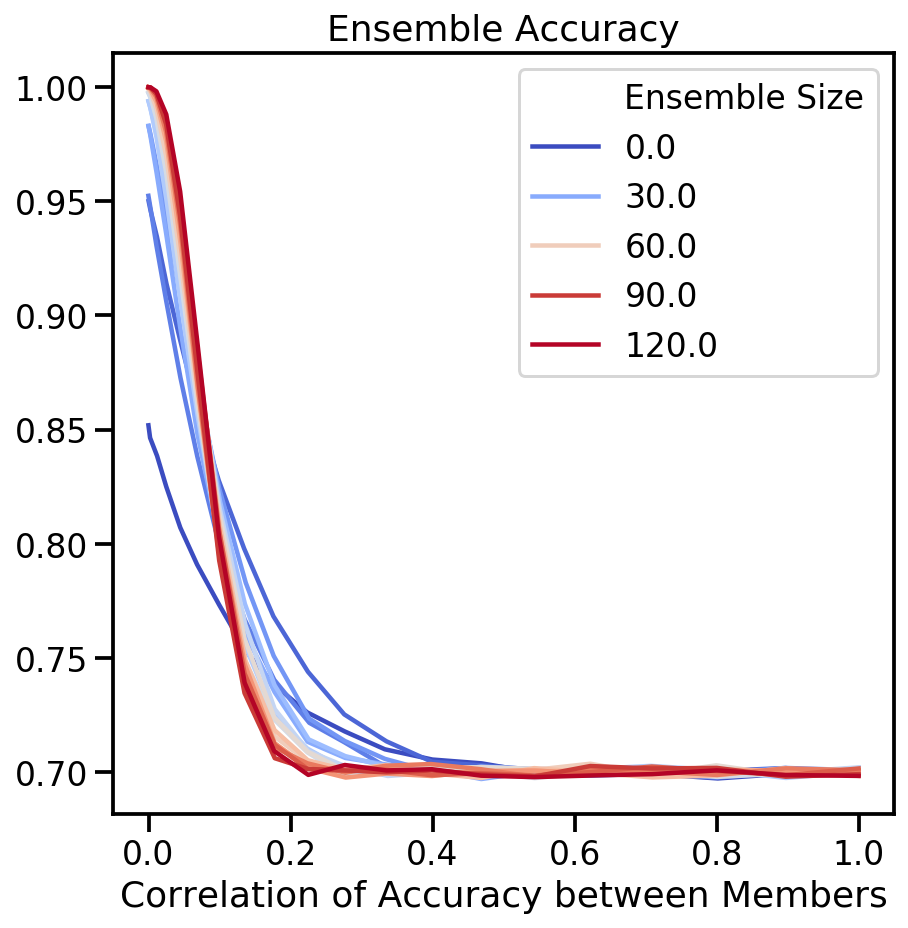

In [344]:
pretty_corr_size_curves = corr_size_curves\
    .reset_index()\
    .astype('float32')\
    .rename(columns={
        'member_mean_corr': 'Correlation of Accuracy between Members',
        'n_members': 'Ensemble Size'
    })

plt.figure(figsize=[7, 7])
sns.lineplot(
    x='Correlation of Accuracy between Members', 
    y='ensemble_accuracy', 
    hue='Ensemble Size', 
    palette='coolwarm',
    data=pretty_corr_size_curves
)

plt.title('Ensemble Accuracy')
plt.ylabel('')
plt.legend(loc='upper right')
plt.show()